In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import SplineTransformer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklego.meta import ZeroInflatedRegressor



from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_squared_error



import seaborn as sns
sns.set()

In [3]:
df = pd.read_csv('./data/train.csv', parse_dates=True)
#df = pd.read_csv('./data/train.csv', parse_dates=True,index_col=0)
df.shape
df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
df['date'] = pd.to_datetime(df['datetime']).dt.date
df['hour'] = pd.to_datetime(df['datetime']).dt.time
df['Month'] = pd.to_datetime(df['datetime']).dt.to_period('M')
df['days'] = pd.to_datetime(df['datetime']).dt.dayofweek
df['months'] = pd.to_datetime(df['datetime']).dt.month
df['year'] = pd.to_datetime(df['datetime']).dt.year
df['hours'] = pd.to_datetime(df['datetime']).dt.hour

## Data Exploration

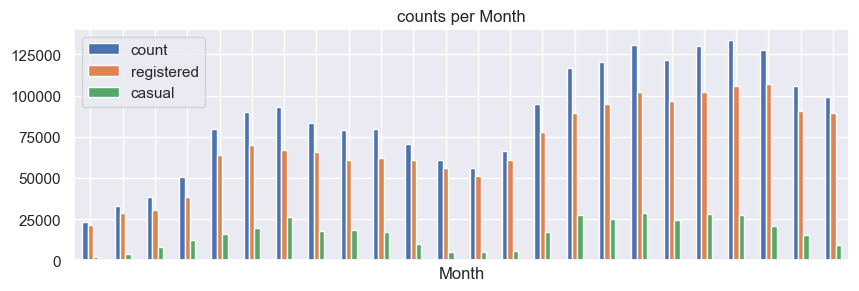

In [5]:
groups_hour = df.groupby(['Month']).agg({"count":"sum", "registered":"sum","casual":"sum"})
fig, ax = plt.subplots()
groups_hour.plot.bar(ax=ax,figsize=(10,3))
plt.title('counts per Month')
plt.setp(ax.get_xticklabels(), visible=False)
plt.show()

Text(0.5, 1.0, 'counts per season')

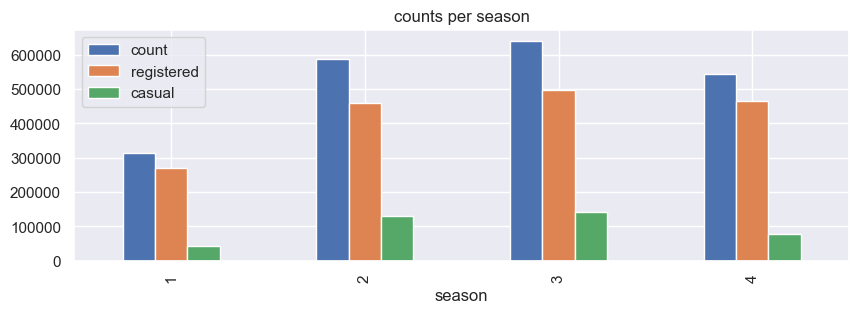

In [6]:
groups_hour = df.groupby(["season"]).agg({"count":"sum", "registered":"sum","casual":"sum"})
groups_hour.plot.bar(figsize=(10,3))
plt.title('counts per season')
#plt.set_xticklabels(df['Month'])

## Explore Daily Hours

Text(0.5, 1.0, 'counts per hour')

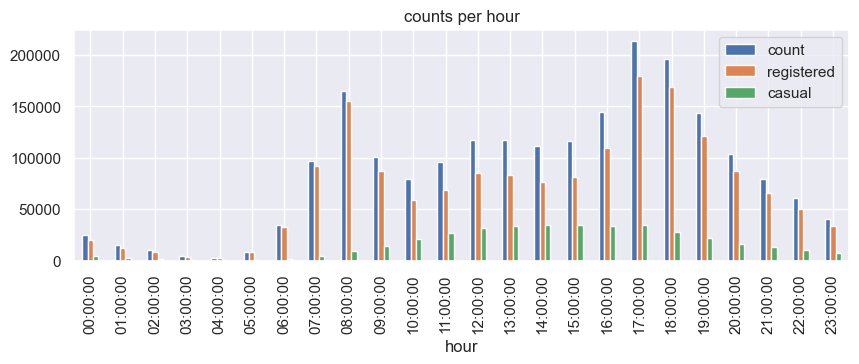

In [7]:
groups_hour = df.groupby(["hour"]).agg({"count":"sum", "registered":"sum","casual":"sum"})
groups_hour.plot.bar(figsize=(10,3))
plt.title('counts per hour')

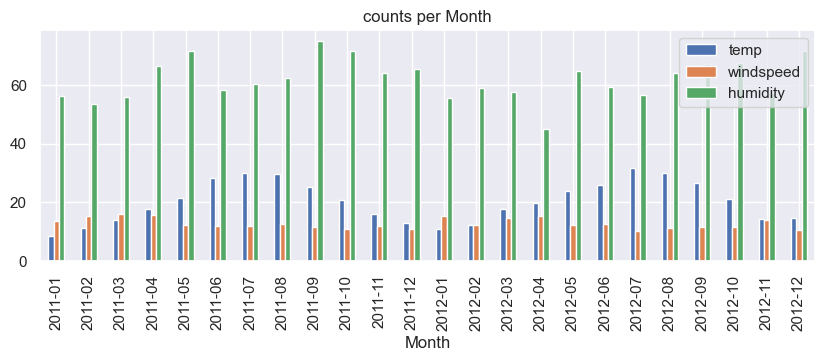

In [8]:
groups_month = df.groupby(['Month']).agg({"temp":"mean", "windspeed":"mean","humidity":"mean"})
#fig, ax = plt.subplots()
#ax1 = groups_month.plot.bar(figsize=(10,3))
groups_month.plot.bar(figsize=(10,3))
plt.title('counts per Month')
#plt.setp(ax.get_xticklabels(), visible=False)
plt.show()

In [9]:
df_casual =df['casual'].value_counts()
df_registered =df['registered'].value_counts()
df_count =df['count'].value_counts()



In [10]:
df_casual = df_casual.where(df_casual>20).dropna()
df_registered = df_registered.where(df_registered>20).dropna()
df_count = df_count.where(df_count>20).dropna()

In [11]:
len(df_casual),len(df_registered),len(df_count)

(93, 212, 189)

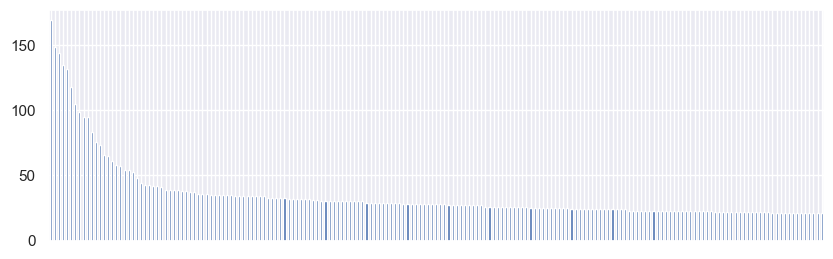

In [12]:
fig, ax = plt.subplots()
df_count.plot.bar(ax=ax,figsize=(10,3))
plt.setp(ax.get_xticklabels(), visible=False)
plt.show()

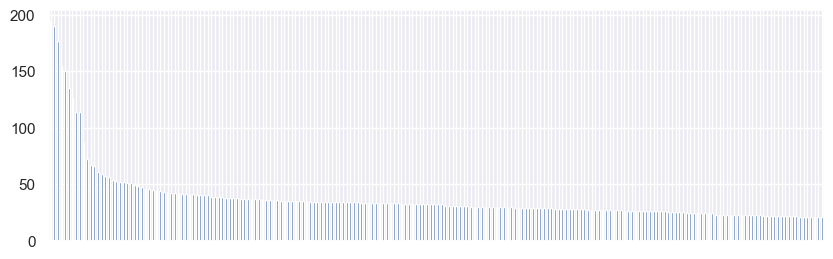

In [13]:
fig, ax = plt.subplots()
df_registered.plot.bar(ax=ax,figsize=(10,3))
plt.setp(ax.get_xticklabels(), visible=False)
plt.show()

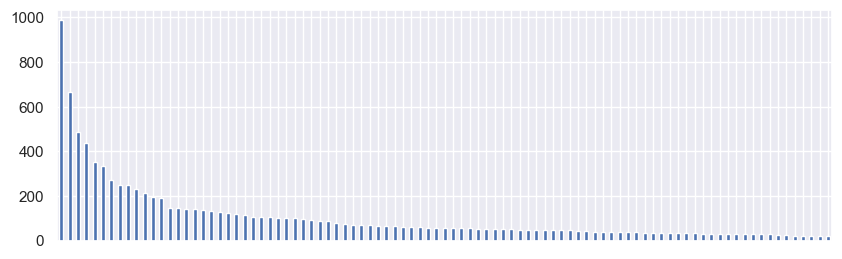

In [14]:
fig, ax = plt.subplots()
df_casual.plot.bar(ax=ax,figsize=(10,3))
plt.setp(ax.get_xticklabels(), visible=False)
plt.show()

## Data Preprocessing

### Column Selection

In [15]:
df=df.set_index('datetime')

In [16]:
df_reg = df.drop(['atemp','count','casual','date', 'Month','hour'], axis=1)
df_cas = df.drop(['atemp','count','registered','date', 'Month','hour'], axis=1)

In [17]:
X_cas = df_cas.drop(['casual'],axis=1)
y_cas =df_cas['casual']
X_reg =df_reg.drop(['registered'],axis=1)
y_reg =df_reg['registered']

### Train Test Split

In [60]:
dfX_train_r, dfX_test_r, dfy_train_r, dfy_test_r = train_test_split(df, np.log1p(df['registered']), test_size=0.33, random_state=42)
dfX_train_r=dfX_train_r.reset_index()

In [18]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cas, np.log1p(y_cas), test_size=0.33, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, np.log1p(y_reg), test_size=0.33, random_state=42)

### Normalization

In [19]:
categorical = ['season', 'weather','holiday','workingday', 'year']
numerical = ['temp', 'humidity', 'windspeed']
cyclic = ['days' ,'hours','months']

In [20]:

preprocessor = ColumnTransformer([
    ("cyclic_hour", SplineTransformer(n_knots=12, extrapolation="periodic"), ["hours"]),
    ("cyclic_days", SplineTransformer(n_knots=15, extrapolation="periodic"), ["days"]),
    ("cyclic_month", SplineTransformer(n_knots=6, extrapolation="periodic"), ["months"]),
    ("categorical", OneHotEncoder(handle_unknown="ignore", drop='first'), categorical),
], remainder=MinMaxScaler())

## Build the Model-Piplines

In [35]:
KNN = Pipeline(steps=[
        ('preprocessor', preprocessor), # preprocessing step
        ('knn', KNeighborsRegressor())  # knn regression
    ]
).fit(X_train_r, y_train_r)

KNN.score(X_train_r, y_train_r)


0.9201154409697155

### Random Forest

In [36]:
RandForest = Pipeline(
    steps=[
        ('preprocessor', preprocessor), # preprocessing step
        ('rf', RandomForestRegressor()) # random forest regression
    ]
).fit(X_train_r, y_train_r)

RandForest.score(X_train_r, y_train_r)

0.991519500987991

In [100]:
dict = {'predictions_reg':np.exp(RandForest.predict(X_train_r))-1}

Predictions_Reg = pd.DataFrame(dict)

#df_pred_r = pd.DataFrame(dfX_train_r, columns=df.columns)

df_pred_r =pd.concat([dfX_train_r,Predictions_Reg],axis=1)

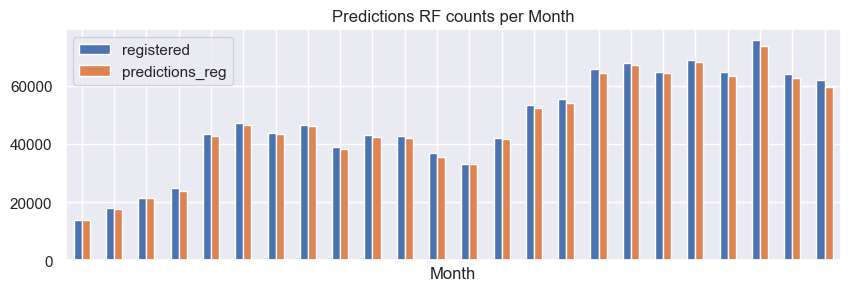

In [103]:

groups_hour = df_pred_r.groupby(['Month']).agg({"registered":"sum","predictions_reg":"sum"})
fig, ax = plt.subplots()
groups_hour.plot.bar(ax=ax,figsize=(10,3))
plt.title('Predictions RF counts per Month')
plt.setp(ax.get_xticklabels(), visible=False)
plt.show()

### Linear Models

In [104]:
Poisson = Pipeline(steps=[
        ('trans',preprocessor),
        ('poisson',PoissonRegressor(alpha=1,max_iter=300))
    ]
).fit(X_train_r, y_train_r)


Poisson.score(X_train_r, y_train_r)



0.31675324069836874

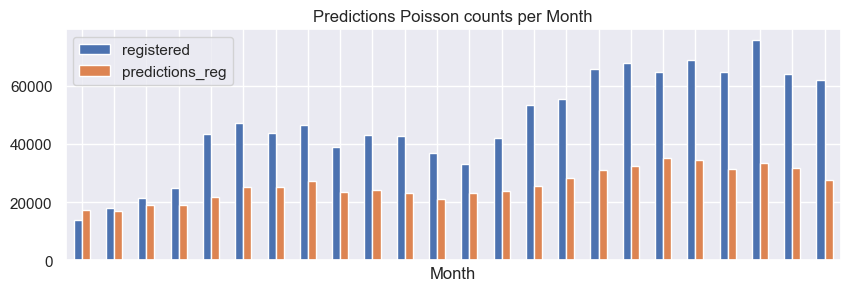

In [111]:
dict = {'predictions_reg':np.exp(Poisson.predict(X_train_r))-1}

Predictions_Reg = pd.DataFrame(dict)
#dfX_train_r=dfX_train_r.reset_index()
#df_pred_r = pd.DataFrame(dfX_train_r, columns=df.columns)

df_pred_r =pd.concat([dfX_train_r,Predictions_Reg],axis=1)

groups_hour = df_pred_r.groupby(['Month']).agg({"registered":"sum","predictions_reg":"sum"})
fig, ax = plt.subplots()
groups_hour.plot.bar(ax=ax,figsize=(10,3))
plt.title('Predictions Poisson counts per Month')
plt.setp(ax.get_xticklabels(), visible=False)
plt.show()

In [37]:
Elastic = Pipeline(
    steps=[
        ('preprocessor', preprocessor), # preprocessing step
        ('rf', ElasticNet()) # random forest regression
    ]
).fit(X_train_r, y_train_r)

Elastic.score(X_train_r, y_train_r)

0.0

### Ridge Regression

In [148]:
Ridgi = Pipeline(
    steps=[
        ('preprocessor', preprocessor), # preprocessing step
        ('rf', Ridge()) # random forest regression
    ]
).fit(X_train_r, y_train_r)

Ridgi.score(X_train_r, y_train_r)

0.8148379560537227

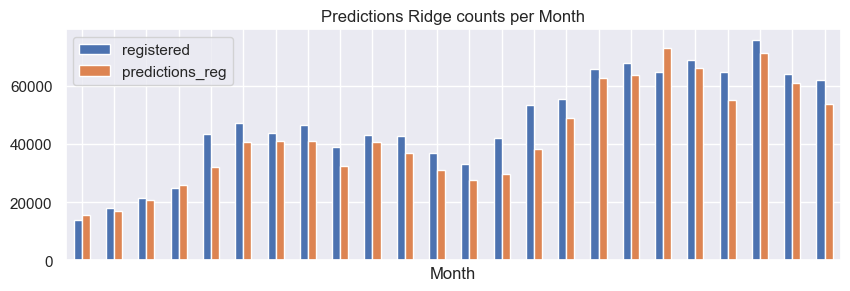

In [109]:
dict = {'predictions_reg':np.exp(Ridgi.predict(X_train_r))-1}

Predictions_Reg = pd.DataFrame(dict)
#dfX_train_r=dfX_train_r.reset_index()
#df_pred_r = pd.DataFrame(dfX_train_r, columns=df.columns)

df_pred_r =pd.concat([dfX_train_r,Predictions_Reg],axis=1)

groups_hour = df_pred_r.groupby(['Month']).agg({"registered":"sum","predictions_reg":"sum"})
fig, ax = plt.subplots()
groups_hour.plot.bar(ax=ax,figsize=(10,3))
plt.title('Predictions Ridge counts per Month')
plt.setp(ax.get_xticklabels(), visible=False)
plt.show()

## Grid Search Cross Validation

In [146]:
param_grid_rf = {
    'rf__n_estimators': [50,100,200,300,500],
    'rf__max_depth': [5,10,20,50,100,None],
    'rf__min_samples_split': [2, 5, 10]
}

gscv = GridSearchCV(
    estimator=RandForest,
    param_grid=param_grid_rf,
    scoring='r2',
    cv=5, 
    n_jobs=-1,
    verbose=1
).fit(X_train_r, y_train_r)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


In [147]:
gscv.best_params_, gscv.best_score_

({'rf__max_depth': None, 'rf__min_samples_split': 5, 'rf__n_estimators': 500},
 0.9371564665980964)

In [151]:
#estimator = ['Poisson', 'KNN', 'RandForest','Elastic']

Ridgi = Pipeline(
    steps=[
        ('preprocessor', preprocessor), # preprocessing step
        ('ridge', Ridge()) # random forest regression
    ]
)
estimator =[Ridgi]
param_grid = {
        'ridge__alpha': [100.,10.,1.,0.1,0.01]
}

In [152]:

gscv = GridSearchCV(
    estimator=Ridgi,
    param_grid=param_grid,
    scoring='r2',
    cv=5, 
    n_jobs=-1,
    verbose=1
).fit(X_train_r, y_train_r)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [153]:
gscv.best_params_

{'ridge__alpha': 1.0}

### Test Model Score

Random Forst Test Score

In [126]:
RandForest.score(X_test_r, y_test_r)

0.9407568460224359

In [125]:
mean_squared_error(np.exp(y_test_r)-1, np.exp(RandForest.predict(X_test_r))-1)

1318.6604651200478

Ridge Test Score

In [149]:
Ridgi.score(X_test_r, y_test_r)

0.8118730239072476

In [150]:
mean_squared_error(np.exp(y_test_r)-1, np.exp(Ridgi.predict(X_test_r))-1)

6967.449234042849